In [102]:
import torch
import os
import torch.nn as nn
import shutil
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchsummary import summary 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

veri setini birleştirme

In [88]:
def organize_data(base_dir, target_dir):
    # Create the target directories if they do not exist
    colour_dir = os.path.join(target_dir, 'colour')
    grey_dir = os.path.join(target_dir, 'grey')
    os.makedirs(colour_dir, exist_ok=True)
    os.makedirs(grey_dir, exist_ok=True)

    # Define the source directories
    cars_colour = os.path.join(base_dir, 'Cars', 'cars_colour')
    cars_gray = os.path.join(base_dir, 'Cars', 'cars_grey')
    flowers_colour = os.path.join(base_dir, 'Flowers', 'flowers_colour')
    flowers_gray = os.path.join(base_dir, 'Flowers', 'flowers_grey')

    # Copy colour images to the colour directory
    for src_dir in [cars_colour, flowers_colour]:
        for filename in os.listdir(src_dir):
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(colour_dir, filename)
            shutil.copyfile(src_file, dst_file)

    # Copy gray images to the gray directory
    for src_dir in [cars_gray, flowers_gray]:
        for filename in os.listdir(src_dir):
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(grey_dir, filename)
            shutil.copyfile(src_file, dst_file)

    print("Data organized successfully.")

# Base directory containing the 'cars' and 'flowers' directories
base_directory = '../../Downloads/data/'
target_dir = './data/'
organize_data(base_directory, target_dir)

Data organized successfully.


Veri setini train, val, test için bölme

In [89]:
def create_directories(base_dir):
    for subset in ['train', 'validation', 'test']:
        for category in ['colour', 'grey']:
            os.makedirs(os.path.join(base_dir, subset, category), exist_ok=True)

def split_and_copy_files(base_dir, filenames, train_ratio=0.7, validation_ratio=0.2):
    train_files, temp_files = train_test_split(filenames, test_size=(1 - train_ratio))
    validation_files, test_files = train_test_split(temp_files, test_size=(1 - validation_ratio / (1 - train_ratio)))

    return train_files, validation_files, test_files

def copy_files(file_list, src_dir, dst_dir):
    for filename in file_list:
        shutil.copyfile(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))

def organize_data(base_dir):
    colour_dir = os.path.join(base_dir, 'colour')
    grey_dir = os.path.join(base_dir, 'grey')

    # List all filenames (assuming the filenames in colour and gray folders are identical)
    filenames = os.listdir(colour_dir)

    # Split the filenames into train, validation, and test sets
    train_files, validation_files, test_files = split_and_copy_files(base_dir, filenames)

    # Create the necessary directories
    create_directories(base_dir)

    # Copy files to the respective directories
    for subset, file_list in zip(['train', 'validation', 'test'], [train_files, validation_files, test_files]):
        copy_files(file_list, colour_dir, os.path.join(base_dir, subset, 'colour'))
        copy_files(file_list, grey_dir, os.path.join(base_dir, subset, 'grey'))

    print("Data organized successfully.")
    

# Base directory containing the 'colour' and 'gray' directories
base_directory = './data'
organize_data(base_directory)


Data organized successfully.


In [90]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = []

        grey_dir = os.path.join(root_dir, "grey")
        color_dir = os.path.join(root_dir, "colour")

        grey_images = sorted(os.listdir(grey_dir))
        color_images = sorted(os.listdir(color_dir))

        for grey_img, color_img in zip(grey_images, color_images):
            self.image_pairs.append((os.path.join(grey_dir, grey_img), os.path.join(color_dir, color_img)))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        grey_img_path, color_img_path = self.image_pairs[idx]
        grey_image = Image.open(grey_img_path).convert('RGB')  # Gri tonlamalı görüntü RGB formatına dönüştürülür
        color_image = Image.open(color_img_path).convert('RGB')  # Renkli görüntü

        if self.transform:
            grey_image = self.transform(grey_image)
            color_image = self.transform(color_image)

        return grey_image, color_image

In [91]:
workspace_path = './data/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = ColorizationDataset(root_dir=os.path.join(workspace_path, "train"), transform=transform)
val_dataset = ColorizationDataset(root_dir=os.path.join(workspace_path, "validation"), transform=transform)
test_dataset = ColorizationDataset(root_dir=os.path.join(workspace_path, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [92]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [93]:
def calculate_accuracy(outputs, targets, tolerance=0.1):
    difference = torch.abs(outputs - targets)
    correct = (difference < tolerance).float().mean()
    return correct

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for grey_images, color_images in train_loader:
        grey_images, color_images = grey_images.to(device), color_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(grey_images)
        loss = criterion(outputs, color_images)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * grey_images.size(0)
        train_accuracy += calculate_accuracy(outputs, color_images).item() * grey_images.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_accuracy / len(train_loader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for grey_images, color_images in val_loader:
            grey_images, color_images = grey_images.to(device), color_images.to(device)
            outputs = model(grey_images)
            loss = criterion(outputs, color_images)
            val_loss += loss.item() * grey_images.size(0)
            val_accuracy += calculate_accuracy(outputs, color_images).item() * grey_images.size(0)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_accuracy / len(val_loader.dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/40], Train Loss: 0.0640, Train Accuracy: 0.2602, Validation Loss: 0.0391, Validation Accuracy: 0.3730
Epoch [2/40], Train Loss: 0.0420, Train Accuracy: 0.3763, Validation Loss: 0.0296, Validation Accuracy: 0.4801
Epoch [3/40], Train Loss: 0.0285, Train Accuracy: 0.5216, Validation Loss: 0.0325, Validation Accuracy: 0.5028
Epoch [4/40], Train Loss: 0.0306, Train Accuracy: 0.5083, Validation Loss: 0.0295, Validation Accuracy: 0.5091
Epoch [5/40], Train Loss: 0.0254, Train Accuracy: 0.5607, Validation Loss: 0.0233, Validation Accuracy: 0.5717
Epoch [6/40], Train Loss: 0.0215, Train Accuracy: 0.6018, Validation Loss: 0.0206, Validation Accuracy: 0.6326
Epoch [7/40], Train Loss: 0.0195, Train Accuracy: 0.6405, Validation Loss: 0.0192, Validation Accuracy: 0.6732
Epoch [8/40], Train Loss: 0.0183, Train Accuracy: 0.6853, Validation Loss: 0.0181, Validation Accuracy: 0.6787
Epoch [9/40], Train Loss: 0.0172, Train Accuracy: 0.6937, Validation Loss: 0.0170, Validation Accuracy: 0.7007
E

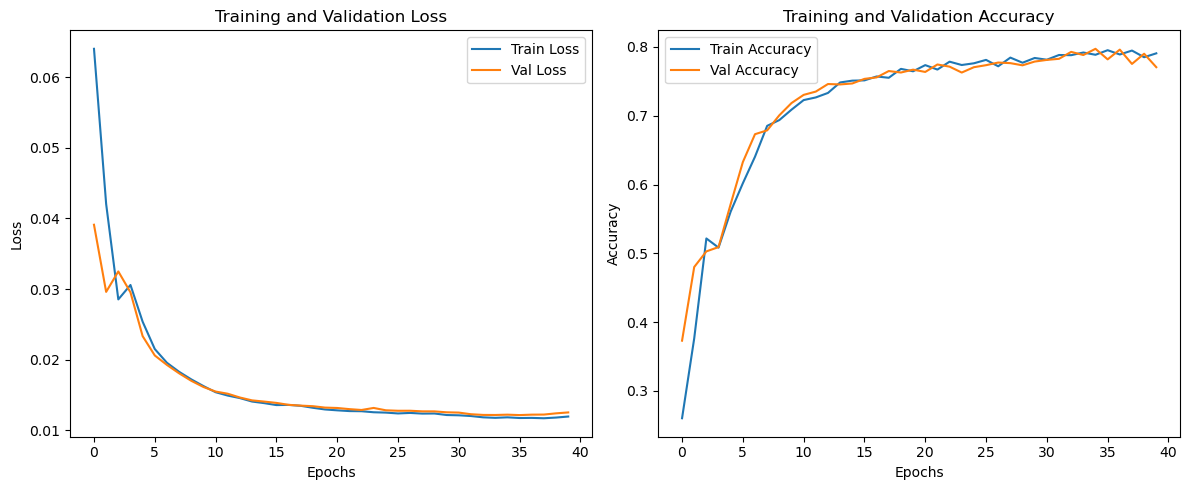

In [97]:
# Eğitim ve doğrulama metriklerini çizdirme
plt.figure(figsize=(12, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

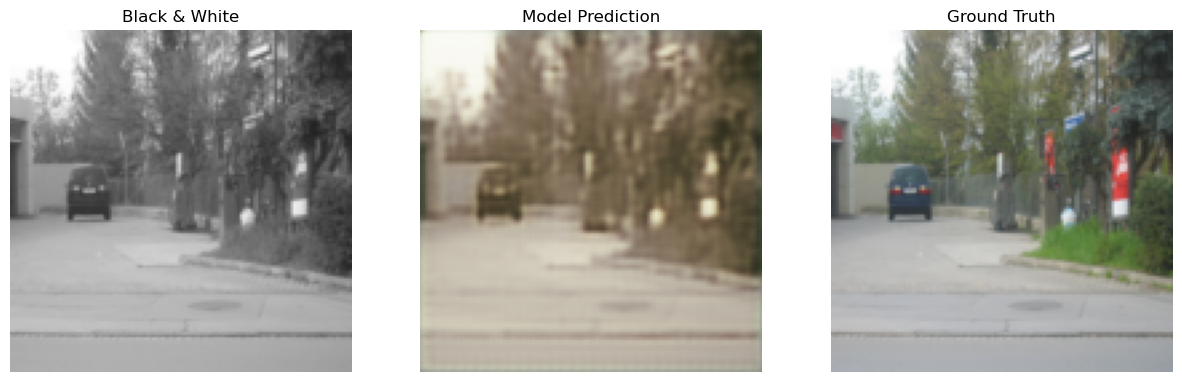

In [113]:
def imshow(image, title=None):
    """ Helper function to display an image tensor. """
    # image is a numpy array already
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# Test aşaması
model.eval()
with torch.no_grad():
    # Get one batch from the test_loader
    for grey_images, color_images in test_loader:
        grey_images, color_images = grey_images.to(device), color_images.to(device)
        outputs = model(grey_images)
        
        # Take the first image in the batch
        grey_image = grey_images[50]
        color_image = color_images[50]
        output_image = outputs[50]
        
        # Move tensors to CPU and normalize to [0, 1]
        grey_image = grey_image.cpu().numpy().transpose(1, 2, 0)
        grey_image = np.clip(grey_image, 0, 1)
        
        color_image = color_image.cpu().numpy().transpose(1, 2, 0)
        color_image = np.clip(color_image, 0, 1)
        
        output_image = output_image.cpu().numpy().transpose(1, 2, 0)
        output_image = np.clip(output_image, 0, 1)
        
        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        imshow(grey_image, 'Black & White')
        
        plt.subplot(1, 3, 2)
        imshow(output_image, 'Model Prediction')
        
        plt.subplot(1, 3, 3)
        imshow(color_image, 'Ground Truth')

        plt.show()
        break  # Only display the first example